In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings related to feature names in decision trees
warnings.filterwarnings("ignore", category=UserWarning, message="X has feature names, but DecisionTreeRegressor was fitted without feature names")

import holidays
from datetime import timedelta

# Load dataset from a Parquet file
dataset_path = './data/lumen/train.parquet'
df = pd.read_parquet(dataset_path)

# Convert date columns to datetime and compute the lead time in days
df['reservation_date'] = pd.to_datetime(df['reservation_date'])
df['date_from'] = pd.to_datetime(df['date_from'])
df['date_to'] = pd.to_datetime(df['date_to'])
df['lead_time_days'] = (df['date_from'] - df['reservation_date']).dt.days

# Remove the first two rows for cleaner data
df = df.iloc[2:]

# Filter the dataframe to include only rows where stay dates are within the booked period
df = df[(df['stay_date'] >= df['date_from']) & (df['stay_date'] <= df['date_to'])]

# Ensure the booking starts on or before it ends
df = df[df['date_from'] <= df['date_to']]

# Filter out entries where the reservation date is after the starting date
df = df[df['reservation_date'] <= df['date_from']]


In [26]:
# Function to expand counts of unique values in a series into a DataFrame
def get_expand_counts(series, prefix):
    counts = series.value_counts().to_dict()
    return pd.DataFrame({f"{prefix}_{k}": [v] for k, v in counts.items()})

# Function to calculate mean aggregates for various columns
def calculate_aggregates(df):
    agg_funcs = {
        'night_number': pd.NamedAgg(column='night_number', aggfunc='mean'),
        'lead_time_days': pd.NamedAgg(column='lead_time_days', aggfunc='mean'),
        'adult_cnt': pd.NamedAgg(column='adult_cnt', aggfunc='mean'),
        'total_price': pd.NamedAgg(column='total_price', aggfunc='mean'),
        'room_cnt': pd.NamedAgg(column='room_cnt', aggfunc=lambda x: x[df.loc[x.index, 'reservation_status'] == 'Checked-out'].sum()),
        'guest_country_id_HR_count': pd.NamedAgg(column='guest_country_id', aggfunc=lambda x: (x == 'HR').sum()),
        'guest_country_id_not_HR_count': pd.NamedAgg(column='guest_country_id', aggfunc=lambda x: (x != 'HR').sum())
    }
    grouped = df.groupby('stay_date').agg(**agg_funcs).reset_index()
    return grouped.fillna(0)

# Function to calculate expected room counts based on conditions
def calculate_expected_room_count(df):
    conditions = (
        (df['reservation_date'] < (df['stay_date'] - pd.Timedelta(days=29))) &
        (df['date_from'] <= df['stay_date']) &
        (df['date_to'] >= df['stay_date']) &
        (~df['reservation_status'].isin(['Cancelled', 'No-show']))
    )
    valid_reservations = df[conditions]
    return valid_reservations.groupby('stay_date').agg(expected_room_cnt=('room_cnt', 'sum')).reset_index()

# Function to merge two dataframes based on 'stay_date'
def merge_dataframes(df1, df2):
    return df1.merge(df2, on='stay_date', how='left').fillna(0)

# Function to resample data on a monthly basis and shift columns for prediction purposes
def resample_data(df):
    df_resampled = df.set_index('stay_date').resample('30D').sum().reset_index()
    df_resampled[['room_cnt', 'expected_room_cnt']] = df_resampled[['room_cnt', 'expected_room_cnt']].shift(1)
    df_resampled['stay_date'] = df_resampled['stay_date'].shift(1)
    return df_resampled.dropna()

# Function to add cyclical features for modeling seasonality
def add_cyclical_features(df, col_name, max_val):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / max_val)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / max_val)
    return df

# Function to perform feature engineering including adding cyclical features
def feature_engineering(df):
    df['month'] = df['stay_date'].dt.month
    df['quarter'] = df['stay_date'].dt.quarter
    df = add_cyclical_features(df, 'month', 12)
    return df

# Function to split data into training and testing datasets based on a cutoff date
def split_data(df, cutoff_date):
    cutoff_date = pd.to_datetime(cutoff_date)
    train_data = df[df['stay_date'] <= cutoff_date].copy()
    test_data = df[df['stay_date'] >= cutoff_date].copy()
    features = [col for col in df.columns if col not in ['stay_date', 'room_cnt']]
    X_train = train_data[features]
    y_train = train_data['room_cnt']
    X_test = test_data[features]
    y_test = test_data['room_cnt']
    return train_data, test_data, X_train, y_train, X_test, y_test

# Function to train a RandomForestRegressor model
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=700, max_depth=8, min_samples_leaf=1, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to plot the importance of different features used by the model
def plot_feature_importance(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title("Feature importances")
    plt.bar(range(len(features)), importances[indices], color="r", align="center")
    plt.xticks(range(len(features)), np.array(features)[indices], rotation=90)
    plt.xlim([-1, len(features)])
    plt.show()

# Function to predict confidence intervals for predictions using the decision trees in the random forest
def predict_intervals(model, X_test, percentile=95):
    predictions = np.array([tree.predict(X_test) for tree in model.estimators_])
    lower_bound = np.percentile(predictions, (100 - percentile) / 2, axis=0)
    upper_bound = np.percentile(predictions, 100 - (100 - percentile) / 2, axis=0)
    return lower_bound, upper_bound

# Function to plot actual vs predicted values along with prediction intervals
def plot_results(X_test_dates, y_test, y_pred, lower_bound, upper_bound):
    plt.figure(figsize=(10, 6))
    plt.plot(X_test_dates, y_test, label='Actual', color='blue')
    plt.plot(X_test_dates, y_pred, label='Predicted', color='red')
    plt.fill_between(X_test_dates, lower_bound, upper_bound, color='gray', alpha=0.5, label='Prediction Interval')
    plt.title('Room Count Forecast with Prediction Intervals')
    plt.xlabel('Date')
    plt.ylabel('Room Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to evaluate how often actual values fall within the predicted intervals
def evaluate_precision(y_test, lower_bound, upper_bound):
    within_interval = ((y_test >= lower_bound) & (y_test <= upper_bound)).mean()
    print(f"Percentage of actual values within predicted interval: {within_interval * 100:.2f}%")

# Function to calculate and print mean squared error and root mean squared error for the model
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

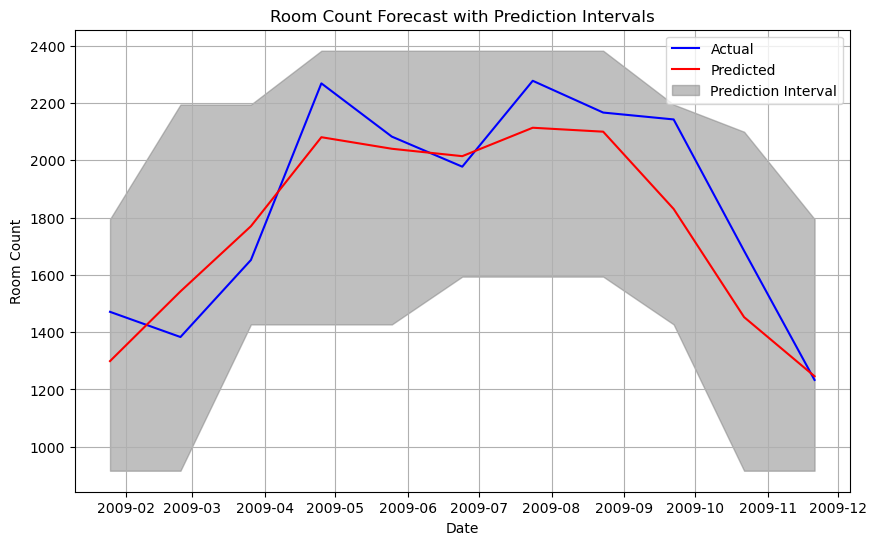

Percentage of actual values within predicted interval: 100.00%
Mean Squared Error: 26393.74
Root Mean Squared Error: 162.46


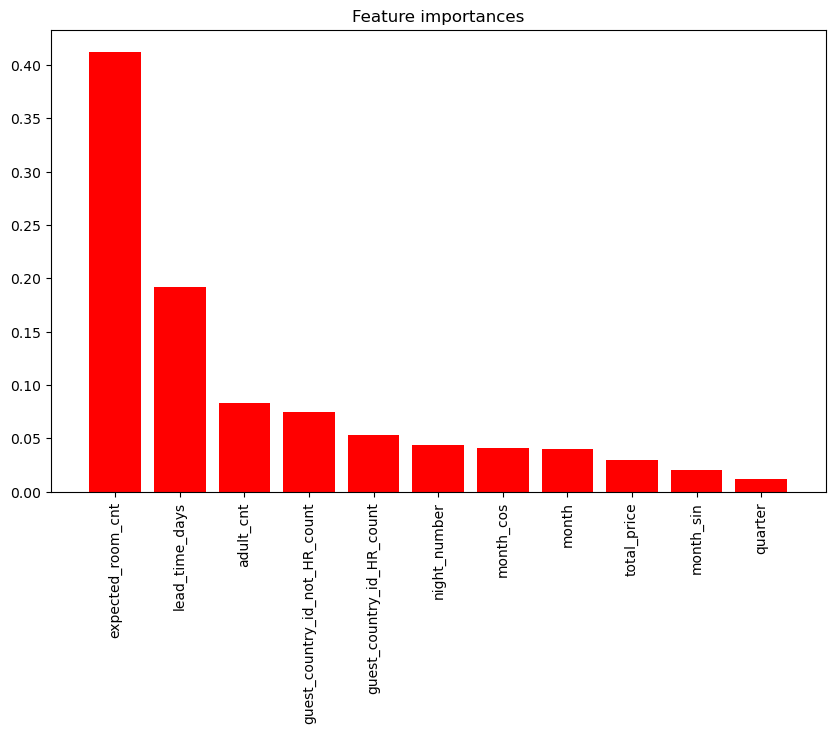

In [28]:
# Calculate aggregate statistics for the DataFrame 'df' after making a copy to avoid altering the original data.
grouped_df = calculate_aggregates(df.copy())

# Calculate the expected room count based on specified conditions within the DataFrame 'df'.
expected_room_cnt = calculate_expected_room_count(df)

# Merge the aggregated data and the expected room counts into a single DataFrame.
final_result = merge_dataframes(grouped_df, expected_room_cnt)

# Apply feature engineering transformations and resample the data weekly.
processed_data = feature_engineering(resample_data(final_result.copy()))

# Split the processed data into training and testing datasets based on the cutoff date '2009-1-3'.
train_data, test_data, X_train, y_train, X_test, y_test = split_data(processed_data, "2009-1-3")

# Train a Random Forest model using the training data.
model = train_model(X_train, y_train)

# Predict the room count using the test data.
y_pred = model.predict(X_test)

# Calculate the prediction intervals for the test predictions using the trained model.
lower_bound, upper_bound = predict_intervals(model, X_test)

# Plot the actual vs. predicted room counts along with the prediction intervals.
plot_results(test_data['stay_date'], y_test, y_pred, lower_bound, upper_bound)

# Evaluate the precision of the predictions by checking the percentage of actual values that fall within the predicted intervals.
evaluate_precision(y_test, lower_bound, upper_bound)

# Calculate and display the model’s performance metrics, specifically mean squared error and root mean squared error.
evaluate_model(y_test, y_pred)

# Plot the importance of each feature used by the model to understand their impact on predictions.
plot_feature_importance(model, X_train.columns)
